# Pick out cues from Accelerometer data

Alternative alignment extraction path for multidevice accelerometry recordings. 

Some recordings include only one tapping or clapping cue, some include multiple.

For a single accelerometry recording:

    0. Load accelerometry file, resample and collapse to 1D absolut Jerk. 
    1. Load all relevant template cues and their approximate position.
    2. Automate IDing each synchronisation cue in the  with cross correlations.
    3. Review cue timing
    4. Save the detected timing of each cue IN DEVICE TIMESTAMP VALUES
    
Output timing information is used in a difference script to shift recordings to common concert time.

## libraries and function files

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport qex
%aimport al

In [607]:
%reload_ext autoreload

# Cue Templates
Pull in the one or many cue templates used to locate cue timing in the jerk data

This sequence constructs the cue from a sequence of peak timings (claps or taps)

In [754]:
synch_times = {'RE_Synch':pd.to_datetime('2023-02-15 10:25:26.573+0000'),
               'RD_Synch':pd.to_datetime('2023-02-15 11:05:36.897+0000'),
               'RD_Reic': pd.to_datetime('2023-02-15 11:16:50.719+0000'),
               'RD_Reic2':pd.to_datetime('2023-02-15 12:02:02.500+0000')}
c_types = {'RE_Synch':'taps',
               'RD_Reic': 'claps',
               'RD_Synch':'taps',
               'RD_Reic2':'claps',} 
cue_files ={'RE_Synch':'./Timing/synch_cue_taps.csv',
               'RD_Reic': './Timing/RD_Reic1.csv',
               'RD_Synch':'./Timing/synch_cue_taps.csv',
               'RD_Reic2':'./Timing/RD_Reic2.csv',} 

In [755]:
synch_times = {'C3_Synch':pd.to_datetime('2023-02-17 08:30:51.841000+00:00'),
               'C3_Reic':pd.to_datetime('2023-02-17 08:40:31.007000+00:00'),
               'C4_Synch': pd.to_datetime('2023-02-17 10:16:29.298000+00:00'),
               'C4_Reic':pd.to_datetime('2023-02-17 10:27:23.179000+00:00')}
c_types = {'C3_Synch':'taps',
               'C3_Reic': 'claps',
               'C4_Synch':'taps',
               'C4_Reic': 'claps',} 
cue_files ={'C3_Synch':'./Timing/short_taps.csv',
               'C3_Reic': './Timing/C3_reic_claps.csv',
               'C4_Synch':'./Timing/short_taps.csv',
               'C4_Reic':'./Timing/C4_reic_claps.csv',} 

In [15]:
synch_times = {'C5_Synch':pd.to_datetime('2023-02-18 15:10:29.583000+00:00'),
               'C5_Reic':pd.to_datetime('2023-02-18 15:22:04.555000+00:00'),}
c_types = {'C5_Synch':'taps',
               'C5_Reic': 'claps',} 
cue_files ={'C5_Synch':'./Timing/short_taps.csv',
               'C5_Reic': './Timing/C5_claps.csv',} 

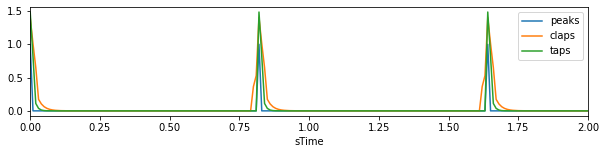

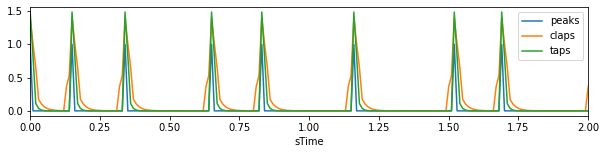

In [16]:
CueT={} # list of cues to check
# sample rate for comparison between cue template and signal
sf = 100
t_range= [-10,20]
for c in synch_times.keys():
    cue_times = pd.read_csv(cue_files[c],",",header=None)
    if len(cue_times.columns)>3:
        cue_times['S_AudioTime'] = np.round(cue_times[0],3) # reset to 50 hz
        cue_times['event'] = cue_times[1]
        cue_times['CTime'] = cue_times['S_AudioTime']-cue_times.loc[3,'S_AudioTime'] # zero on onset of first synch cue
        peak_times = cue_times.loc[cue_times['event'].str.startswith('Tap'),'CTime']
    else:
        peak_times = list(cue_times[0]-cue_times.loc[0,0])
    
    cue = al.cue_template_make(peak_times,sf,t_range)

    cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[10,2])
    plt.xlim([0,2])
    plt.show()
    CueT[c] = cue 

In [17]:
# Interval of time taken from signal to search for cue
cue

,sTime,peaks,taps,claps
0,-10.00,0,0.0,0.0
1,-9.99,0,0.0,0.0
2,-9.98,0,0.0,0.0
3,-9.97,0,0.0,0.0
4,-9.96,0,0.0,0.0
...,...,...,...,...
2995,19.95,0,0.0,0.0
2996,19.96,0,0.0,0.0
2997,19.97,0,0.0,0.0
2998,19.98,0,0.0,0.0


In [25]:
keys = list(CueT.keys())

# Acc Data load
This notebook is initially build for processing Equivital data from the Bodies in Concert 

In [443]:
player_order = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104','VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204','VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304','LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404','WW505','WW502','WW503','WW506','WW501','WW504','WW507','BR604','BR603','BR602','BR606','BR607','BR605','BR601','PC704','PC705','PC703','PC701','PC702','PC707']

eq_files = pd.DataFrame(index =player_order,columns = ['RG','RE','RD','C1','C2','C3','C4','C5'])

In [456]:
eq_data_loc = '../Data/Equivital/Lydo_Rehearsal/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(eq_data_loc,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
eq_files.loc[:,'RG']=df_datafiles['ACCloc']
eq_files.loc[:,'RE']=df_datafiles['ACCloc']
eq_files.loc[:,'RD']=df_datafiles['ACCloc']
#eq_data_loc + 'FASTACC'+ df_datafiles.loc[pid,'FileName'][4:]

In [457]:
df_datafiles['ACCloc']

DevName
VA308    ../Data/Equivital/Lydo_Rehearsal/FASTACC-VA308...
LS402    ../Data/Equivital/Lydo_Rehearsal/FASTACC-LS402...
BR606    ../Data/Equivital/Lydo_Rehearsal/FASTACC-BR606...
VN207    ../Data/Equivital/Lydo_Rehearsal/FASTACC-VN207...
LS406    ../Data/Equivital/Lydo_Rehearsal/FASTACC-LS406...
LS404    ../Data/Equivital/Lydo_Rehearsal/FASTACC-LS404...
LS403    ../Data/Equivital/Lydo_Rehearsal/FASTACC-LS403...
LS408    ../Data/Equivital/Lydo_Rehearsal/FASTACC-LS408...
PC703    ../Data/Equivital/Lydo_Rehearsal/FASTACC-PC703...
VA306    ../Data/Equivital/Lydo_Rehearsal/FASTACC-VA306...
PC705    ../Data/Equivital/Lydo_Rehearsal/FASTACC-PC705...
VA305    ../Data/Equivital/Lydo_Rehearsal/FASTACC-VA305...
LS410    ../Data/Equivital/Lydo_Rehearsal/FASTACC-LS410...
VA307    ../Data/Equivital/Lydo_Rehearsal/FASTACC-VA307...
VN208    ../Data/Equivital/Lydo_Rehearsal/FASTACC-VN208...
VN204    ../Data/Equivital/Lydo_Rehearsal/FASTACC-VN204...
VN209    ../Data/Equivital/Lydo_Rehearsal/FASTAC

In [458]:
eq_data_loc = '../Data/Equivital/Lydo_C1_C2/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(eq_data_loc,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
eq_files.loc[:,'C1']=df_datafiles['ACCloc']
eq_files.loc[:,'C2']=df_datafiles['ACCloc']

In [459]:
eq_data_loc = '../Data/Equivital/230217_Lydo_Concerts/CSV/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(eq_data_loc,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
eq_files.loc[:,'C3']=df_datafiles['ACCloc']
eq_files.loc[:,'C4']=df_datafiles['ACCloc']

In [460]:
eq_data_loc = '../Data/Equivital/230218_Lydo_Concerts/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(eq_data_loc,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
eq_files.loc[:,'C5']=df_datafiles['ACCloc']

In [462]:
eq_files.to_csv('raw_EQ_filelocs.csv')

In [20]:
pi = 0
player_order = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104','VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204','VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304','LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404','WW505','WW502','WW503','WW506','WW501','WW504','WW507','BR604','BR603','BR602','BR606','BR607','BR605','BR601','PC704','PC705','PC703','PC701','PC702','PC707']
pid = player_order[pi]

In [21]:
cues_aligned = pd.DataFrame(columns = synch_times.keys())

In [230]:
cues_aligned = pd.read_csv('RE_RD_Equivitals.csv', index_col = 0)
for c in cues_aligned.columns:
    cues_aligned[c] = pd.to_datetime(cues_aligned[c])
print(len(cues_aligned))
cues_aligned

55


,RE_Synch,RD_Synch,RD_Reic,RD_Reic2
VN102,2023-02-15 10:25:26.493000+00:00,2023-02-15 11:05:36.497000+00:00,2023-02-15 11:16:50.469000+00:00,2023-02-15 12:01:59.190000+00:00
VN107,NaT,NaT,2023-02-15 11:16:53.069000+00:00,2023-02-15 12:02:01.800000+00:00
VN106,2023-02-15 10:25:27.483000+00:00,2023-02-15 11:05:37.647000+00:00,2023-02-15 11:16:51.639000+00:00,2023-02-15 12:02:00.560000+00:00
VN108,2023-02-15 10:25:27.473000+00:00,2023-02-15 11:05:37.597000+00:00,2023-02-15 11:16:51.689000+00:00,NaT
VN101,2023-02-15 10:25:25.863000+00:00,2023-02-15 11:05:35.837000+00:00,NaT,2023-02-15 12:01:58.590000+00:00
VN105,2023-02-15 10:25:26.873000+00:00,2023-02-15 11:05:36.977000+00:00,2023-02-15 11:16:50.909000+00:00,2023-02-15 12:01:59.660000+00:00
VN103,2023-02-15 10:25:26.673000+00:00,2023-02-15 11:05:36.677000+00:00,2023-02-15 11:16:52.809000+00:00,2023-02-15 12:01:59.520000+00:00
VN104,2023-02-15 10:25:26.873000+00:00,2023-02-15 11:05:36.917000+00:00,2023-02-15 11:16:50.919000+00:00,2023-02-15 12:01:59.660000+00:00
VN205,2023-02-15 10:25:27.193000+00:00,2023-02-15 11:05:37.337000+00:00,2023-02-15 11:16:51.349000+00:00,2023-02-15 12:02:00.250000+00:00
VN203,2023-02-15 10:25:27.143000+00:00,2023-02-15 11:05:37.367000+00:00,2023-02-15 11:16:51.379000+00:00,2023-02-15 12:02:00.270000+00:00


In [230]:
cues_aligned = pd.read_csv('C3_C4_Equivitals.csv', index_col = 0)
for c in cues_aligned.columns:
    cues_aligned[c] = pd.to_datetime(cues_aligned[c])
print(len(cues_aligned))
cues_aligned

55


,RE_Synch,RD_Synch,RD_Reic,RD_Reic2
VN102,2023-02-15 10:25:26.493000+00:00,2023-02-15 11:05:36.497000+00:00,2023-02-15 11:16:50.469000+00:00,2023-02-15 12:01:59.190000+00:00
VN107,NaT,NaT,2023-02-15 11:16:53.069000+00:00,2023-02-15 12:02:01.800000+00:00
VN106,2023-02-15 10:25:27.483000+00:00,2023-02-15 11:05:37.647000+00:00,2023-02-15 11:16:51.639000+00:00,2023-02-15 12:02:00.560000+00:00
VN108,2023-02-15 10:25:27.473000+00:00,2023-02-15 11:05:37.597000+00:00,2023-02-15 11:16:51.689000+00:00,NaT
VN101,2023-02-15 10:25:25.863000+00:00,2023-02-15 11:05:35.837000+00:00,NaT,2023-02-15 12:01:58.590000+00:00
VN105,2023-02-15 10:25:26.873000+00:00,2023-02-15 11:05:36.977000+00:00,2023-02-15 11:16:50.909000+00:00,2023-02-15 12:01:59.660000+00:00
VN103,2023-02-15 10:25:26.673000+00:00,2023-02-15 11:05:36.677000+00:00,2023-02-15 11:16:52.809000+00:00,2023-02-15 12:01:59.520000+00:00
VN104,2023-02-15 10:25:26.873000+00:00,2023-02-15 11:05:36.917000+00:00,2023-02-15 11:16:50.919000+00:00,2023-02-15 12:01:59.660000+00:00
VN205,2023-02-15 10:25:27.193000+00:00,2023-02-15 11:05:37.337000+00:00,2023-02-15 11:16:51.349000+00:00,2023-02-15 12:02:00.250000+00:00
VN203,2023-02-15 10:25:27.143000+00:00,2023-02-15 11:05:37.367000+00:00,2023-02-15 11:16:51.379000+00:00,2023-02-15 12:02:00.270000+00:00


In [109]:
pid = 'VN208'
pi = 14

## Set up Cue detection through a whole set
With mechanism to correct entries

Cycle from here

In [384]:
pid= player_order[pi]
print(pid)

PC707


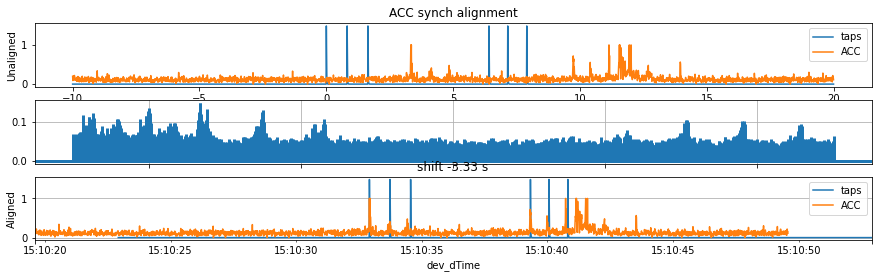

2023-02-18 15:10:32.913000+00:00


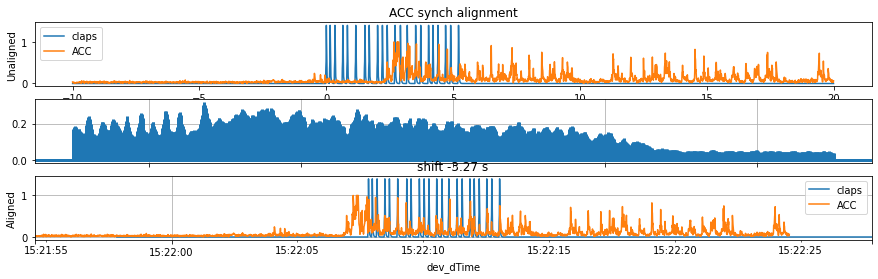

2023-02-18 15:22:07.825000+00:00


In [385]:
sigFileLoc = eq_data_loc + 'FASTACC'+ df_datafiles.loc[pid,'FileName'][4:]
V = pd.read_csv(sigFileLoc,skipinitialspace=True)
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime']) 
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
Results = {}

for c in synch_times.keys():
    cue = CueT[c].copy()
    prelim_synch_time = synch_times[c]
    c_type = c_types[c] 

    Res = al.min_align(ACC,cue.loc[:,['sTime',c_type]],prelim_synch_time,5)
    Results[c] = Res
    cues_aligned.loc[pid,c] = Res['best']
    print(Res['best'])

Check individual alignments

In [373]:
i = 0
c = keys[i]
print(c)

C5_Synch


In [369]:
cues_aligned.loc[pid,c] = np.datetime64('NaT')

C5_Synch


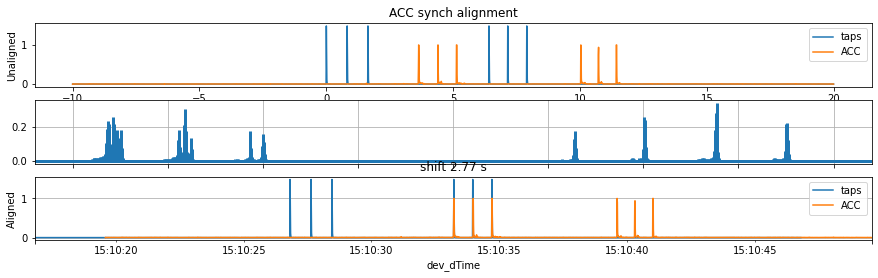

,ind,corr,shift s
0,37,0.236160,-3.63
1,42,0.259644,-3.58
2,118,0.304280,-2.82
3,601,0.260842,2.01
4,677,0.342367,2.77
5,751,0.222523,3.51


In [374]:
print(c)
shift_limits = 4 # set the range of shifts (+/-) tests. It can be up to the length used to generate the results
Res = al.min_align(ACC,CueT[c].loc[:,['sTime',c_types[c]]],synch_times[c],shift_limits)

ccthresh = 0.19# set threshold below 

peaks = al.alt_xc_peaks(Res,ccthresh)
peaks

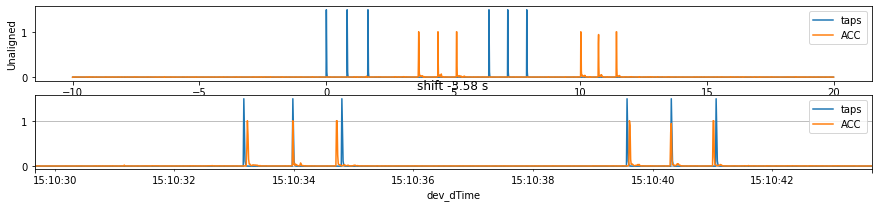

2023-02-18 15:10:33.163000+00:00


In [376]:
# specify the shift 6ou want to check by peak or enter a shift offset in seconds in test_shift
pk_int =1
cues_aligned.loc[pid,c] = al.test_shift(Res,peaks.loc[pk_int,'shift s'])
print(cues_aligned.loc[pid,c])

In [386]:
#cues_aligned.to_csv('RE_RD_Equivitals.csv')
#cues_aligned.to_csv('C3_C4_Equivitals.csv')
cues_aligned.to_csv('C5_Equivitals.csv')
pi+=1
cues_aligned.iloc[-2:,:]

,C5_Synch,C5_Reic
PC702,2023-02-18 15:10:32.703000+00:00,2023-02-18 15:22:07.655000+00:00
PC707,2023-02-18 15:10:32.913000+00:00,2023-02-18 15:22:07.825000+00:00


In [327]:
pid

'BR602'

# device time variance

In [387]:
cols = cues_aligned.columns
cols 

Index(['C5_Synch', 'C5_Reic'], dtype='object')

In [388]:
cues_aligned

,C5_Synch,C5_Reic
VN102,2023-02-18 15:10:32.123000+00:00,2023-02-18 15:22:07.055000+00:00
VN107,2023-02-18 15:10:33.033000+00:00,2023-02-18 15:22:08.025000+00:00
VN106,2023-02-18 15:10:33.433000+00:00,2023-02-18 15:22:08.415000+00:00
VN108,2023-02-18 15:10:32.753000+00:00,2023-02-18 15:22:07.785000+00:00
VN101,2023-02-18 15:10:32.253000+00:00,2023-02-18 15:22:07.225000+00:00
VN105,2023-02-18 15:10:32.163000+00:00,2023-02-18 15:22:07.115000+00:00
VN103,2023-02-18 15:10:31.663000+00:00,2023-02-18 15:22:06.645000+00:00
VN104,2023-02-18 15:10:32.063000+00:00,2023-02-18 15:22:07.075000+00:00
VN205,2023-02-18 15:10:32.153000+00:00,2023-02-18 15:22:07.185000+00:00
VN203,2023-02-18 15:10:32.953000+00:00,2023-02-18 15:22:07.995000+00:00


In [407]:
sync_diffs = pd.DataFrame(index = cues_aligned.index)
for i in range(len(cols)):
    for j in range(i):
        dif_tag = cols[j] + '-' + cols[i]
        sync_diffs[dif_tag] = (cues_aligned[cols[j]] - cues_aligned[cols[i]]).dt.total_seconds()

sync_diffs =  sync_diffs-sync_diffs.median()
sync_diffs['Deviance'] = sync_diffs.abs().sum(axis = 1)
print(sync_diffs.median())
print(sync_diffs.std())

#sync_diffs

C5_Synch-C5_Reic    0.00
Deviance            0.03
dtype: float64
C5_Synch-C5_Reic    0.042684
Deviance            0.025235
dtype: float64


In [408]:
sync_diffs.loc[:,'Deviance'].sort_values()

BR607    0.00
VN107    0.00
LS404    0.00
VA304    0.00
VA303    0.00
BR603    0.00
WW501    0.00
PC705    0.00
VN204    0.00
WW503    0.00
VN210    0.00
LS410    0.01
VA302    0.01
LS401    0.01
PC701    0.01
VN103    0.01
BR605    0.01
VN106    0.01
PC703    0.01
LS403    0.02
BR601    0.02
VN104    0.02
VN101    0.02
VN208    0.03
VN207    0.03
WW505    0.03
VA301    0.03
LS408    0.03
WW502    0.04
WW507    0.04
VA306    0.04
LS406    0.04
VN205    0.04
VN108    0.04
PC704    0.04
PC702    0.04
VN105    0.04
BR604    0.04
LS402    0.05
VA307    0.05
VN201    0.05
VN206    0.05
VN203    0.05
LS407    0.05
VN102    0.06
BR602    0.06
VN209    0.06
VN202    0.06
LS405    0.07
VA308    0.07
WW506    0.07
WW504    0.08
PC707    0.08
BR606    0.09
Name: Deviance, dtype: float64

# Correct excessive deviations

In [409]:
pid = 'BR606' # WW504    6107.171 vs 6107.9 ish
print(sync_diffs.loc[pid,:])

C5_Synch-C5_Reic   -0.09
Deviance            0.09
Name: BR606, dtype: float64


In [410]:
sigFileLoc = eq_data_loc + 'FASTACC'+ df_datafiles.loc[pid,'FileName'][4:]
V = pd.read_csv(sigFileLoc,skipinitialspace=True)
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime']) 
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
Results = {}

C5_Synch-C5_Reic   -0.09
Deviance            0.09
Name: BR606, dtype: float64
C5_Synch


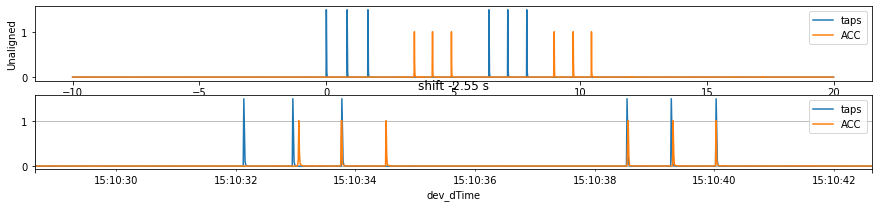

C5_Reic


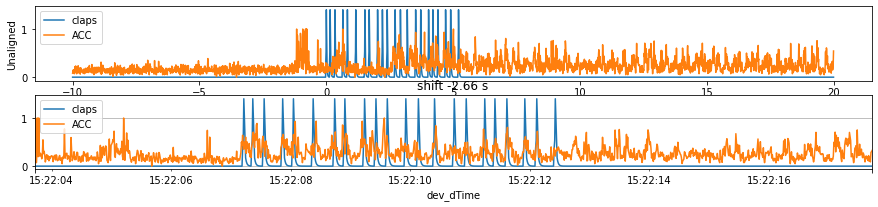

In [411]:
print(sync_diffs.loc[pid,:])
for c in synch_times.keys():
    print(c)
    cue = CueT[c].copy()
    prelim_synch_time = synch_times[c]
    c_type = c_types[c] 

    Res = al.min_align_noplot(ACC,cue.loc[:,['sTime',c_type]],prelim_synch_time,5)
    Results[c] = Res
    al.test_shift(Res,cues_aligned.loc[pid,c])

In [403]:
c = cols[1]

C5_Reic


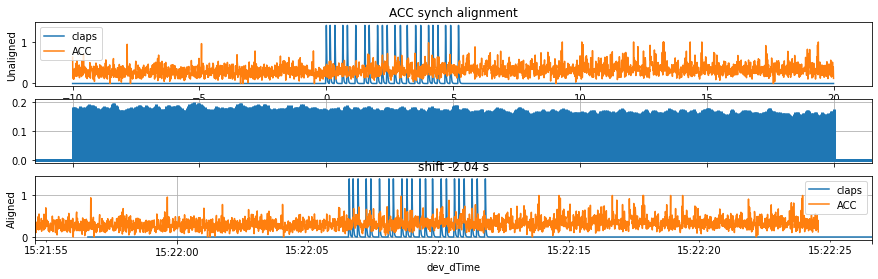

,ind,corr,shift s
0,2,0.183505,-2.98
1,4,0.180622,-2.96
2,6,0.185211,-2.94
3,8,0.183698,-2.92
4,13,0.192631,-2.87
5,15,0.189950,-2.85
6,25,0.187639,-2.75
7,27,0.182714,-2.73
8,32,0.197351,-2.68
9,46,0.181791,-2.54


In [405]:
print(c)
shift_limits = 3 # set the range of shifts (+/-) tests. It can be up to the length used to generate the results
Res = al.min_align(ACC,CueT[c].loc[:,['sTime',c_types[c]]],synch_times[c],shift_limits)

ccthresh = 0.18 # set threshold below 
peaks = al.alt_xc_peaks(Res,ccthresh)
peaks

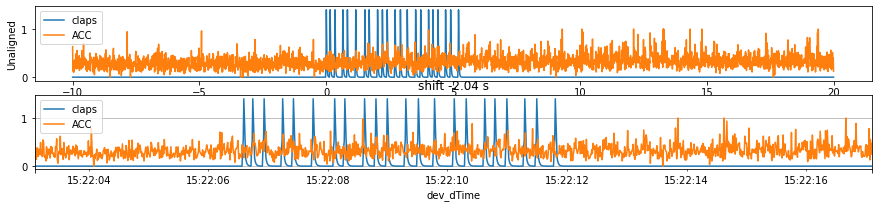

2023-02-18 15:22:06.595000+00:00


In [406]:
# specify the shift you want to check by peak or enter a shift offset in seconds in test_shift
pk_int =17
cues_aligned.loc[pid,c] = al.test_shift(Res,peaks.loc[pk_int,'shift s'])
print(cues_aligned.loc[pid,c])

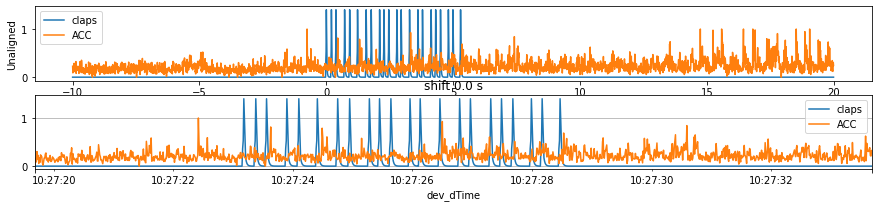

2023-02-17 10:27:23.179000+00:00


In [1376]:
cues_aligned.loc[pid,c] = al.test_shift(Res,0.0)
print(cues_aligned.loc[pid,c])

## Save after making adjustments

In [412]:
cues_aligned.to_csv('C5_Equivitals.csv')

# Gather and check sensor clock deviance
There is variation in alignment quality that may be due to clock drift. 

Assess whether specific sensors have a tendency to be fast or slow by comparing time between sample points on different days.


In [414]:
all_cues = {'RE_Synch':pd.to_datetime('2023-02-15 10:25:26.573+0000'),
               'RD_Synch':pd.to_datetime('2023-02-15 11:05:36.897+0000'),
               'RD_Reic': pd.to_datetime('2023-02-15 11:16:50.719+0000'),
               'RD_Reic2':pd.to_datetime('2023-02-15 12:02:02.500+0000'),
              'C1_Synch':pd.to_datetime('2023-02-16 8:33:18.324+0000'),
               'C1_Reic':pd.to_datetime('2023-02-16 08:45:22.246+0000'),#'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
               'C2_Synch':pd.to_datetime('2023-02-16 10:16:22.697+0000'),
               'C2_Reic':pd.to_datetime('2023-02-16 10:27:10.927+0000'),
              'C3_Synch':pd.to_datetime('2023-02-17 08:30:51.841000+00:00'),
               'C3_Reic':pd.to_datetime('2023-02-17 08:40:31.007000+00:00'),
               'C4_Synch': pd.to_datetime('2023-02-17 10:16:29.298000+00:00'),
               'C4_Reic':pd.to_datetime('2023-02-17 10:27:23.179000+00:00'),
              'C5_Synch':pd.to_datetime('2023-02-18 15:10:29.583000+00:00'),
               'C5_Reic':pd.to_datetime('2023-02-18 15:22:04.555000+00:00')}

In [413]:
cues_aligned = pd.read_csv('RE_RD_Equivitals.csv', index_col = 0)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C1_C2_Equivitals.csv', index_col = 0)],axis=1)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C3_C4_Equivitals.csv', index_col = 0)],axis=1)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C5_Equivitals.csv', index_col = 0)],axis=1)

for c in cues_aligned.columns:
    cues_aligned[c] = pd.to_datetime(cues_aligned[c])
print(len(cues_aligned))
cues_aligned

55


,RE_Synch,RD_Synch,RD_Reic,RD_Reic2,C1_Synch,C1_Reic,C2_Synch,C2_Reic,C3_Synch,C3_Reic,C4_Synch,C4_Reic,C5_Synch,C5_Reic
VN102,2023-02-15 10:25:26.493000+00:00,2023-02-15 11:05:36.497000+00:00,2023-02-15 11:16:50.469000+00:00,2023-02-15 12:01:59.190000+00:00,2023-02-16 08:33:18.264000+00:00,2023-02-16 08:45:22.016000+00:00,2023-02-16 10:16:21.637000+00:00,2023-02-16 10:27:09.787000+00:00,2023-02-17 08:30:50.421000+00:00,2023-02-17 08:40:29.557000+00:00,2023-02-17 10:16:24.668000+00:00,2023-02-17 10:27:18.499000+00:00,2023-02-18 15:10:32.123000+00:00,2023-02-18 15:22:07.055000+00:00
VN107,NaT,NaT,2023-02-15 11:16:53.069000+00:00,2023-02-15 12:02:01.800000+00:00,NaT,2023-02-16 08:45:23.396000+00:00,NaT,2023-02-16 10:27:11.347000+00:00,2023-02-17 08:30:52.331000+00:00,2023-02-17 08:40:31.437000+00:00,2023-02-17 10:16:26.918000+00:00,2023-02-17 10:27:20.679000+00:00,2023-02-18 15:10:33.033000+00:00,2023-02-18 15:22:08.025000+00:00
VN106,2023-02-15 10:25:27.483000+00:00,2023-02-15 11:05:37.647000+00:00,2023-02-15 11:16:51.639000+00:00,2023-02-15 12:02:00.560000+00:00,2023-02-16 08:33:19.384000+00:00,2023-02-16 08:45:23.256000+00:00,2023-02-16 10:16:23.097000+00:00,2023-02-16 10:27:11.257000+00:00,NaT,NaT,NaT,NaT,2023-02-18 15:10:33.433000+00:00,2023-02-18 15:22:08.415000+00:00
VN108,2023-02-15 10:25:27.473000+00:00,2023-02-15 11:05:37.597000+00:00,2023-02-15 11:16:51.689000+00:00,NaT,2023-02-16 08:33:19.864000+00:00,2023-02-16 08:45:23.586000+00:00,2023-02-16 10:16:23.417000+00:00,2023-02-16 10:27:11.567000+00:00,2023-02-17 08:30:51.421000+00:00,2023-02-17 08:40:30.597000+00:00,2023-02-17 10:16:26.038000+00:00,2023-02-17 10:27:19.809000+00:00,2023-02-18 15:10:32.753000+00:00,2023-02-18 15:22:07.785000+00:00
VN101,2023-02-15 10:25:25.863000+00:00,2023-02-15 11:05:35.837000+00:00,NaT,2023-02-15 12:01:58.590000+00:00,NaT,2023-02-16 08:45:23.086000+00:00,2023-02-16 10:16:22.717000+00:00,2023-02-16 10:27:10.727000+00:00,2023-02-17 08:30:51.431000+00:00,2023-02-17 08:40:30.587000+00:00,2023-02-17 10:16:25.698000+00:00,2023-02-17 10:27:19.449000+00:00,2023-02-18 15:10:32.253000+00:00,2023-02-18 15:22:07.225000+00:00
VN105,2023-02-15 10:25:26.793000+00:00,2023-02-15 11:05:36.897000+00:00,2023-02-15 11:16:50.909000+00:00,2023-02-15 12:01:59.660000+00:00,2023-02-16 08:33:19.014000+00:00,2023-02-16 08:45:22.896000+00:00,2023-02-16 10:16:22.437000+00:00,2023-02-16 10:27:10.607000+00:00,2023-02-17 08:30:52.041000+00:00,2023-02-17 08:40:31.167000+00:00,2023-02-17 10:16:26.318000+00:00,2023-02-17 10:27:20.169000+00:00,2023-02-18 15:10:32.163000+00:00,2023-02-18 15:22:07.115000+00:00
VN103,2023-02-15 10:25:26.673000+00:00,2023-02-15 11:05:36.677000+00:00,2023-02-15 11:16:50.659000+00:00,2023-02-15 12:01:59.520000+00:00,2023-02-16 08:33:19.414000+00:00,2023-02-16 08:45:23.266000+00:00,2023-02-16 10:16:22.777000+00:00,2023-02-16 10:27:10.987000+00:00,2023-02-17 08:30:51.971000+00:00,2023-02-17 08:40:31.057000+00:00,2023-02-17 10:16:26.308000+00:00,2023-02-17 10:27:20.079000+00:00,2023-02-18 15:10:31.663000+00:00,2023-02-18 15:22:06.645000+00:00
VN104,2023-02-15 10:25:26.873000+00:00,2023-02-15 11:05:36.917000+00:00,2023-02-15 11:16:50.919000+00:00,2023-02-15 12:02:02.500000+00:00,2023-02-16 08:33:19.874000+00:00,2023-02-16 08:45:23.726000+00:00,2023-02-16 10:16:23.207000+00:00,2023-02-16 10:27:11.417000+00:00,2023-02-17 08:30:52.931000+00:00,2023-02-17 08:40:32.077000+00:00,2023-02-17 10:16:27.238000+00:00,2023-02-17 10:27:21.039000+00:00,2023-02-18 15:10:32.063000+00:00,2023-02-18 15:22:07.075000+00:00
VN205,2023-02-15 10:25:27.193000+00:00,2023-02-15 11:05:37.337000+00:00,2023-02-15 11:16:51.349000+00:00,2023-02-15 12:02:00.250000+00:00,2023-02-16 08:33:20.374000+00:00,2023-02-16 08:45:24.166000+00:00,2023-02-16 10:16:23.947000+00:00,2023-02-16 10:27:12.127000+00:00,2023-02-17 08:30:53.001000+00:00,2023-02-17 08:40:32.157000+00:00,2023-02-17 10:16:27.508000+00:00,2023-02-17 10:27:21.369000+00:00,2023-02-18 15:10:32.153000+00:00,2023-02-18 15:22:07

In [415]:
df = (cues_aligned - all_cues)#.dt.total_seconds() # (cues_aligned[cols[j]] - cues_aligned[cols[i]]).dt.total_seconds()
for c in df.columns:
    df[c] = df[c].dt.total_seconds()
df

,RE_Synch,RD_Synch,RD_Reic,RD_Reic2,C1_Synch,C1_Reic,C2_Synch,C2_Reic,C3_Synch,C3_Reic,C4_Synch,C4_Reic,C5_Synch,C5_Reic
VN102,-0.08,-0.40,-0.25,-3.31,-0.06,-0.23,-1.06,-1.14,-1.42,-1.45,-4.63,-4.68,2.54,2.50
VN107,NaN,NaN,2.35,-0.70,NaN,1.15,NaN,0.42,0.49,0.43,-2.38,-2.50,3.45,3.47
VN106,0.91,0.75,0.92,-1.94,1.06,1.01,0.40,0.33,NaN,NaN,NaN,NaN,3.85,3.86
VN108,0.90,0.70,0.97,NaN,1.54,1.34,0.72,0.64,-0.42,-0.41,-3.26,-3.37,3.17,3.23
VN101,-0.71,-1.06,NaN,-3.91,NaN,0.84,0.02,-0.20,-0.41,-0.42,-3.60,-3.73,2.67,2.67
VN105,0.22,0.00,0.19,-2.84,0.69,0.65,-0.26,-0.32,0.20,0.16,-2.98,-3.01,2.58,2.56
VN103,0.10,-0.22,-0.06,-2.98,1.09,1.02,0.08,0.06,0.13,0.05,-2.99,-3.10,2.08,2.09
VN104,0.30,0.02,0.20,0.00,1.55,1.48,0.51,0.49,1.09,1.07,-2.06,-2.14,2.48,2.52
VN205,0.62,0.44,0.63,-2.25,2.05,1.92,1.25,1.20,1.16,1.15,-1.79,-1.81,2.57,2.63
VN203,0.57,0.47,0.66,-2.23,0.85,0.71,0.14,0.07,1.06,0.98,-1.89,-1.91,3.37,3.44


In [418]:
df.median()

RE_Synch    0.430
RD_Synch    0.275
RD_Reic     0.570
RD_Reic2   -2.305
C1_Synch    1.190
C1_Reic     1.135
C2_Synch    0.485
C2_Reic     0.420
C3_Synch    0.425
C3_Reic     0.375
C4_Synch   -2.460
C4_Reic    -2.505
C5_Synch    2.740
C5_Reic     2.775
dtype: float64